# MaLSTM - Quora Duplicate Question Pairs

In [10]:
from time import time
import pandas as pd
import numpy as np
import boto
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Merge
import keras.backend as K
from keras.optimizers import Adadelta, Adam
from keras.callbacks import ModelCheckpoint

import pickle

### Import data

In [4]:
train_csv_path = 'data/train.csv'
test_csv_path = 'data/test.csv'
word2vec_path = 'google_news_word_vectors/GoogleNews-vectors-negative300.bin'

In [5]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [6]:
train_df.shape

(404290, 6)

## Processing Steps:

> __1. Clean each sentence__
> __2. Create a vocabulary of all the words seen in the dataset__
> 3. Replace the words in their sentences with their vocabulary indices
> 4. Reference word2vec and build an embedding matrix__

In [32]:
stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text






vocabulary = dict()
inverse_vocabulary = ['<unk>']
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

questions_cols = ['question1', 'question2']



for dataset in [train_df]:
    for index, row in dataset.iterrows():

        for question in questions_cols:

            q2n = []
            for word in text_to_word_list(row[question]):

                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            dataset.set_value(index, question, q2n)
            

            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)
embeddings[0] = 0 

for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec

/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


##### Check if the vocabulary contains good words

In [33]:
inverse_vocabulary

['<unk>',
 'what',
 'is',
 'the',
 'step',
 'by',
 'guide',
 'invest',
 'in',
 'share',
 'market',
 'india',
 'story',
 'kohinoor',
 'koh',
 '-',
 'i',
 'noor',
 'diamond',
 'would',
 'happen',
 'if',
 'indian',
 'government',
 'stole',
 'back',
 'how',
 'can',
 'increase',
 'speed',
 'my',
 'internet',
 'connection',
 'while',
 'using',
 'vpn',
 'be',
 'increased',
 'hacking',
 'through',
 'dns',
 'why',
 'am',
 'mentally',
 'very',
 'lonely',
 'solve',
 'it',
 'find',
 'remainder',
 'when',
 'math',
 '23',
 '^',
 '24',
 'divided',
 'which',
 'one',
 'dissolve',
 'water',
 'quikly',
 'sugar',
 'salt',
 'methane',
 'carbon',
 'di',
 'oxide',
 'fish',
 'survive',
 'astrology',
 ':',
 'capricorn',
 'sun',
 'cap',
 'moon',
 'rising',
 'does',
 'that',
 'say',
 'about',
 'me',
 'triple',
 'ascendant',
 'this',
 'should',
 'buy',
 'tiago',
 'keeps',
 'childern',
 'active',
 'far',
 'from',
 'phone',
 'video',
 'games',
 'good',
 'geologist',
 'do',
 'great',
 'you',
 'use',
 'instead',
 'mo

##### Dump the vocabulary to a pickle

In [34]:
pickle.dump( vocabulary, open( "model/vocabulary_train.p", "wb" ) )
pickle.dump( inverse_vocabulary, open( "model/inverse_vocabulary_train.p", "wb" ) )
pickle.dump( embeddings, open( "model/embeddings_train.p", "wb" ) )

##### 1. Find out the maximum question length
##### 2. Split the dataset into training, validation and testing
##### 3. DO NOT shuffle the dataset as we need the same set of examples to train in other classifiers and ensemble as well
##### 4. Pad the dataset to the maximum question length to prepare the data

In [42]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 50000
training_size = 304290
test_size = 50000

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train = X.iloc[0:training_size]
X_validation = X.iloc[training_size:training_size+validation_size]
X_test = X.iloc[training_size+validation_size:training_size+validation_size+test_size]

Y_train = Y.iloc[0:training_size]
Y_validation = Y.iloc[training_size:training_size+validation_size]
Y_test = Y.iloc[training_size+validation_size:training_size+validation_size+test_size]

X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': X_test.question1, 'right': X_test.question2}

Y_train = Y_train.values
Y_validation = Y_validation.values
Y_test = Y_test.values



# Pad to max_seq_length
for dataset, side in itertools.product([X_train, X_validation, X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)


    
    
# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)
assert X_validation['left'].shape == X_validation['right'].shape
assert len(X_validation['left']) == len(Y_validation)
assert X_test['left'].shape == X_test['right'].shape
assert len(X_test['left']) == len(Y_test)

##### Print out the maximum question length

In [2]:
max_seq_length

212

##### Plot the length of questions in the dataset

In [7]:
count = 0
questionLengthDict = dict()
posQuestionLengthDict = dict()
negQuestionLengthDict = dict()

for index, row in train_df.iterrows():
    q1 = str(row["question1"])
    q2 = str(row["question2"])
    q1l = len(q1)
    q2l = len(q2)
    if q1l in questionLengthDict:
        questionLengthDict[q1l] = questionLengthDict[q1l] + 1
    else:
        questionLengthDict[q1l] = 1
    
    if q2l in questionLengthDict:
        questionLengthDict[q2l] = questionLengthDict[q2l] + 1
    else:
        questionLengthDict[q2l] = 1
    
    if bool(row["is_duplicate"]):
        if q1l in posQuestionLengthDict:
            posQuestionLengthDict[q1l] = posQuestionLengthDict[q1l] + 1
        else:
            posQuestionLengthDict[q1l] = 1

        if q2l in posQuestionLengthDict:
            posQuestionLengthDict[q2l] = posQuestionLengthDict[q2l] + 1
        else:
            posQuestionLengthDict[q2l] = 1
    else:
        if q1l in negQuestionLengthDict:
            negQuestionLengthDict[q1l] = negQuestionLengthDict[q1l] + 1
        else:
            negQuestionLengthDict[q1l] = 1

        if q2l in negQuestionLengthDict:
            negQuestionLengthDict[q2l] = negQuestionLengthDict[q2l] + 1
        else:
            negQuestionLengthDict[q2l] = 1
        
    count+=1

print(count)

404290


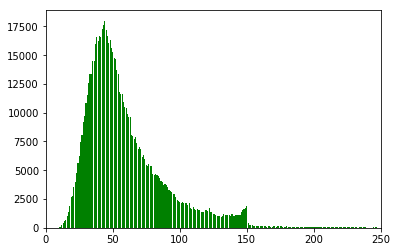

In [8]:
plt.bar(list(questionLengthDict.keys()), questionLengthDict.values(), color='g')
plt.xlim(0,250)
plt.show()

##### Validate the shapes of X's and Y's

In [ ]:
print(X_train['left'].shape)
print(X_train['right'].shape)
print(X_validation['left'].shape)
print(X_validation['right'].shape)
print(X_test['left'].shape)
print(X_test['right'].shape)


print(Y_train.shape)
print(Y_validation.shape)
print(Y_test.shape)

##### Build the model

In [ ]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 25

def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# Input tensor placeholders
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

# Embedding layer
embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Add the embedding dimension to input placeholders
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Initialise the LSTM
shared_lstm = LSTM(n_hidden)
left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the manhattan distance
malstm_distance = Merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Build the model
malstm = Model([left_input, right_input], [malstm_distance])
optimizer = Adam(clipnorm=gradient_clipping_norm)
malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])




training_start_time = time() 

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Total training time for {} epochs is {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

##### Save the model

In [120]:
import h5py

malstm.save('model/malstm_full_run_train_csv_final.h5')

##### Load the model

In [112]:
# malstm = Model([left_input, right_input], [malstm_distance])
# malstm.load_weights('model/malstm_full_run_train_csv.h5')

##### Get predictions from model and save them to pickles

In [122]:
predictions_train = malstm.predict([X_train['left'], X_train['right']], batch_size=batch_size)
predictions_train = [item for sublist in predictions_train for item in sublist]

pickle.dump( predictions_train, open( "model/predictions_lstm_full_run_train_csv_final.p", "wb" ) )



predictions_valid = malstm.predict([X_validation['left'], X_validation['right']], batch_size=batch_size)
predictions_valid = [item for sublist in predictions_valid for item in sublist]

pickle.dump( predictions_valid, open( "model/predictions_lstm_full_run_valid_csv_final.p", "wb" ) )




predictions_test = malstm.predict([X_test['left'], X_test['right']], batch_size=batch_size)
predictions_test = [item for sublist in predictions_test for item in sublist]

pickle.dump( predictions_test, open( "model/predictions_lstm_full_run_test_csv_final.p", "wb" ) )

##### Print predictions

In [123]:
print(predictions_test[0:10])
print(Y_test[0:10])

[0.4844021, 0.90710443, 0.22426711, 0.5713104, 0.22823608, 0.27226216, 0.00033382987, 0.15369949, 0.6488062, 0.16378202]
[1 1 0 1 1 0 0 0 0 0]


##### Convert predictions to bool

In [124]:
predictions_test_bool = [(prediction > 0.5) for prediction in predictions_test]

print(sum(predictions_test_bool == (Y_test == 1)))

41524


##### Plot the results

Confusion matrix, without normalization
[[29085  3309]
 [ 5167 12439]]


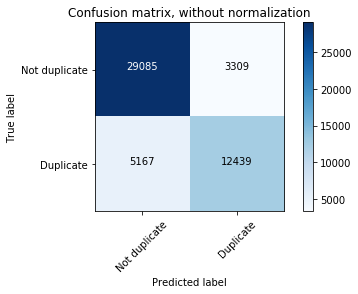

In [125]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
y_test = Y_test
y_pred = predictions_test_bool

cnf_matrix = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Not duplicate','Duplicate'],
                      title='Confusion matrix, without normalization')


Accuracy:  0.83048
Recall:  0.706520504373509
Precision:  0.7898780797561595
F1 score:  0.7458775559153326
ROC AUC score:  0.8021859791732335
Average precision-recall score: 0.83


Text(0.5,1,'2-class Precision-Recall curve: AP=0.83')

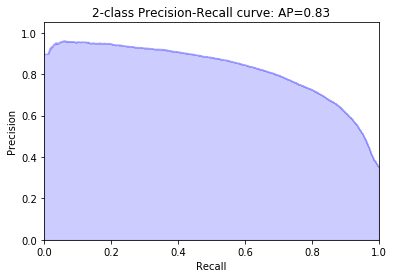

In [126]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

y_test = Y_test
y_pred = predictions_test_bool
y_pred_prob = predictions_test

rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy: ", acc)
print("Recall: ", rec)
print("Precision: ", prec)
print("F1 score: ", f1)
print("ROC AUC score: ", roc_auc)


from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred_prob)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))